In [1]:
# -*- coding: utf-8 -*-

In [167]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import spacy
import seaborn as sns

In [3]:
import os
import sys

## Handle the CV files

In [58]:
cv_path = os.path.join(os.getcwd(), 'data', 'sharepoint', 'cv')
cvs = os.listdir(cv_path)
cvs

['albert danielsen.txt',
 'asle kambuås.txt',
 'even øie.txt',
 'fredric mentezoni.txt',
 'ida rosen.txt',
 'ivar østby.txt',
 'magnus karlsen.txt',
 'magnus øye.txt',
 'maria soleim.txt',
 'ove stokke.txt',
 'per johannes schiager.txt',
 'richard michael pedersen.txt',
 'roger flataker.txt',
 'sara haugen.txt',
 'simen vevik.txt',
 'stian olsen.txt',
 'ståle singstad.txt',
 'susanne sekkesæter.txt',
 'tina danielsen.txt',
 'tollef jørgensen.txt',
 'tove-mette brennhaug.txt',
 'vegard walmsness.txt']

In [64]:
def get_cv(name):
    return os.path.join(cv_path, name)

In [65]:
example = get_cv('albert danielsen.txt')
example

'C:\\Users\\tollef\\Documents\\Git\\nlp-intro\\data\\sharepoint\\cv\\albert danielsen.txt'

## Preprosessering

In [108]:
# prepare spacy nlp object
spacy_model = 'nb_core_news_lg'
nlp = spacy.load(spacy_model)
nlp.add_pipe('sentencizer')

In [109]:
def flat_map(xs):
    ys = []
    for x in xs:
        ys.extend(x)
    return ys

def clean_sent(sent):
    escapes = ['\n', '\t', '\r']
    def valid(tok):
        return tok not in escapes
    
    for e in escapes:
        sent = sent.replace(e, ' ')
    
    return sent

MIN_LEN = 20        
def get_sentences(data):
    sents = []
    for sent in data:
        # clean the raw text
        cleaned = clean_sent(sent).strip()
        # parse possible sub-sentences using spacy
        doc = nlp(cleaned)
        sub_sents = [s.text for s in doc.sents if len(s.text) > MIN_LEN]
        sents.append(sub_sents)
    return flat_map(sents)

In [110]:
data = None
with open(example, 'r', encoding='utf-8') as f:
    data = f.readlines()

In [111]:
sents = get_sentences(data)

In [278]:
all_texts = []
all_labels = []

for cv_name in cvs:
    with open(get_cv(cv_name), 'r', encoding='utf-8') as f:
        data = f.readlines()
        sents = get_sentences(data)
        all_texts.extend(sents)
        labels = len(sents) * [cv_name.replace('.txt', '')]
        all_labels.extend(labels)

## Gjør om til dataframe

In [279]:
columns = ['text', 'konsulent']
df = pd.DataFrame(list(zip(all_texts, all_labels)), columns=columns)
df

,text,konsulent
0,Albert er en svilingeniør innen kybernetikk og...,albert danielsen
1,Han har opparbeidet seg bred erfaring innen pr...,albert danielsen
2,Nylig har Albert jobbet i et prosjekt for Alte...,albert danielsen
3,Hans bidrag i dette prosjektet består i front-...,albert danielsen
4,i et domain driven design-mønster.,albert danielsen
...,...,...
1383,2019-07 - Microsoft 365 Certified:,vegard walmsness
1384,Administrator Associate,vegard walmsness
1385,Certified Fundamentals,vegard walmsness
1386,Administering and Deploying System Center Conf...,vegard walmsness


In [280]:
sample = df.text[1]
sample

'Han har opparbeidet seg bred erfaring innen programvareutvikling fra sine prosjekter hos tidligere arbeidsgivere og som konsulent.'

In [281]:
doc = nlp(sample)
print([token.lemma_ for token in doc])
print([tok for tok in doc])

['han', 'har', 'opparbeide', 'seg', 'bred', 'erfaring', 'innen', 'programvareutvikling', 'fra', 'sine', 'prosjekt', 'hos', 'tidlig', 'arbeidsgiver', 'og', 'som', 'konsulent', '.']
[Han, har, opparbeidet, seg, bred, erfaring, innen, programvareutvikling, fra, sine, prosjekter, hos, tidligere, arbeidsgivere, og, som, konsulent, .]


In [282]:
def get_ent(ent):
    return [ent.text, ent.start_char, ent.end_char, ent.label_]

def enrich(row):
    doc = nlp(row.text)
    
    lemmas = [token.lemma_ for token in doc]
    row['lemmas'] = lemmas
    
    ents = [get_ent(ent) for ent in doc.ents]
    row['ents'] = ents
    
    tokens = [tok for tok in doc]
    row['tokens'] = tokens
    
    return row

df = df.apply(enrich, axis=1)

In [283]:
df

,text,konsulent,lemmas,ents,tokens
0,Albert er en svilingeniør innen kybernetikk og...,albert danielsen,"[Albert, er, en, svilingeniør, innen, kybernet...","[[Albert, 0, 6, PER], [NTNU, 70, 74, ORG]]","[Albert, er, en, svilingeniør, innen, kybernet..."
1,Han har opparbeidet seg bred erfaring innen pr...,albert danielsen,"[han, har, opparbeide, seg, bred, erfaring, in...",[],"[Han, har, opparbeidet, seg, bred, erfaring, i..."
2,Nylig har Albert jobbet i et prosjekt for Alte...,albert danielsen,"[nylig, har, Albert, jobbe, i, et, prosjekt, f...","[[Albert, 10, 16, PER], [Altera Infrastructure...","[Nylig, har, Albert, jobbet, i, et, prosjekt, ..."
3,Hans bidrag i dette prosjektet består i front-...,albert danielsen,"[hans, bidrag, i, dette, prosjekt, bestå, i, f...","[[Vue, 103, 106, ORG]]","[Hans, bidrag, i, dette, prosjektet, består, i..."
4,i et domain driven design-mønster.,albert danielsen,"[i, et, domain, driven, design-mønster, .]",[],"[i, et, domain, driven, design-mønster, .]"
...,...,...,...,...,...
1383,2019-07 - Microsoft 365 Certified:,vegard walmsness,"[2019-07, -, Microsoft, 365, Certified, :]","[[Microsoft, 10, 19, ORG]]","[2019-07, -, Microsoft, 365, Certified, :]"
1384,Administrator Associate,vegard walmsness,"[administrator, Associate]",[],"[Administrator, Associate]"
1385,Certified Fundamentals,vegard walmsness,"[Certified, Fundamentals]",[],"[Certified, Fundamentals]"
1386,Administering and Deploying System Center Conf...,vegard walmsness,"[Administering, and, Deploying, System, Center...",[],"[Administering, and, Deploying, System, Center..."


In [284]:
def get_texts_from_name(name):
    return list(df[(df.konsulent.str.contains(name))].text)

get_texts_from_name('albert')[:3]

['Albert er en svilingeniør innen kybernetikk og robotikk, utdannet ved NTNU, med spesialisering innen embedded systems.',
 'Han har opparbeidet seg bred erfaring innen programvareutvikling fra sine prosjekter hos tidligere arbeidsgivere og som konsulent.',
 'Nylig har Albert jobbet i et prosjekt for Altera Infrastructure, et stort skipsrederi, med mål om å digitalisere arbeidsflyten ved modifikasjoner på skip i drift.']

In [285]:
STOPPORD = ['gjennom', 'as', 'innen', 'å', 'alle', 'at', 'av', 'både', 'båe', 'bare', 'begge', 'ble', 'blei', 'bli', 'blir', 'blitt', 'då', 'da', 'de', 'deg', 'dei', 'deim', 'deira', 'deires', 'dem', 'den', 'denne', 'der', 'dere', 'deres', 'det', 'dette', 'di', 'din', 'disse', 'ditt', 'du', 'dykk', 'dykkar', 'eg', 'ein', 'eit', 'eitt', 'eller', 'elles', 'en', 'enn', 'er', 'et', 'ett', 'etter', 'før', 'for', 'fordi', 'fra', 'ha', 'hadde', 'han', 'hans', 'har', 'hennar', 'henne', 'hennes', 'her', 'hjå', 'ho', 'hoe', 'honom', 'hoss', 'hossen', 'hun', 'hva', 'hvem', 'hver', 'hvilke', 'hvilken', 'hvis', 'hvor', 'hvordan', 'hvorfor', 'i', 'ikke', 'ikkje', 'ingen', 'ingi', 'inkje', 'inn', 'inni', 'ja', 'jeg', 'kan', 'kom', 'korleis', 'korso', 'kun', 'kunne', 'kva', 'kvar', 'kvarhelst', 'kven', 'kvi', 'kvifor', 'man', 'mange', 'me', 'med', 'medan', 'meg', 'meget', 'mellom', 'men', 'mi', 'min', 'mine', 'mitt', 'mot', 'mykje', 'nå', 'når', 'ned', 'no', 'noe', 'noen', 'noka', 'noko', 'nokon', 'nokor', 'nokre', 'og', 'også', 'om', 'opp', 'oss', 'over', 'på', 'så', 'sånn', 'samme', 'seg', 'selv', 'si', 'sia', 'sidan', 'siden', 'sin', 'sine', 'sitt', 'sjøl', 'skal', 'skulle', 'slik', 'so', 'som', 'somme', 'somt', 'til', 'um', 'upp', 'ut', 'uten', 'vår', 'være', 'vært', 'var', 'vart', 'varte', 'ved', 'vere', 'verte', 'vi', 'vil', 'ville', 'vore', 'vors', 'vort']
len(STOPPORD)

175

In [286]:
NAVN = [cv.replace('.txt', '').split() for cv in cvs]
NAVN = flat_map(NAVN)

In [287]:
FY_ORD = []
FY_ORD.extend(STOPPORD)
FY_ORD.extend(NAVN)

In [288]:
corpus = [tok.text.lower() for tok in flat_map(list(df.tokens)) if len(tok) > 1]
len(corpus)

14666

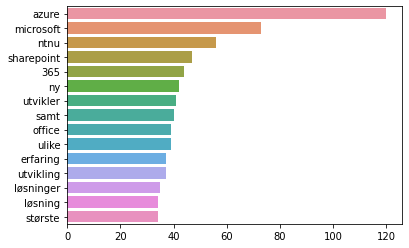

In [289]:
from collections import Counter
counter=Counter(corpus)
most=counter.most_common()

x, y= [], []
for word,count in most[:40]:
    if (word.lower() not in FY_ORD):
        x.append(count)
        y.append(word)

def plot_n_words(n=20):
    sns.barplot(x=x[:n], y=y[:n])
    
plot_n_words(30)

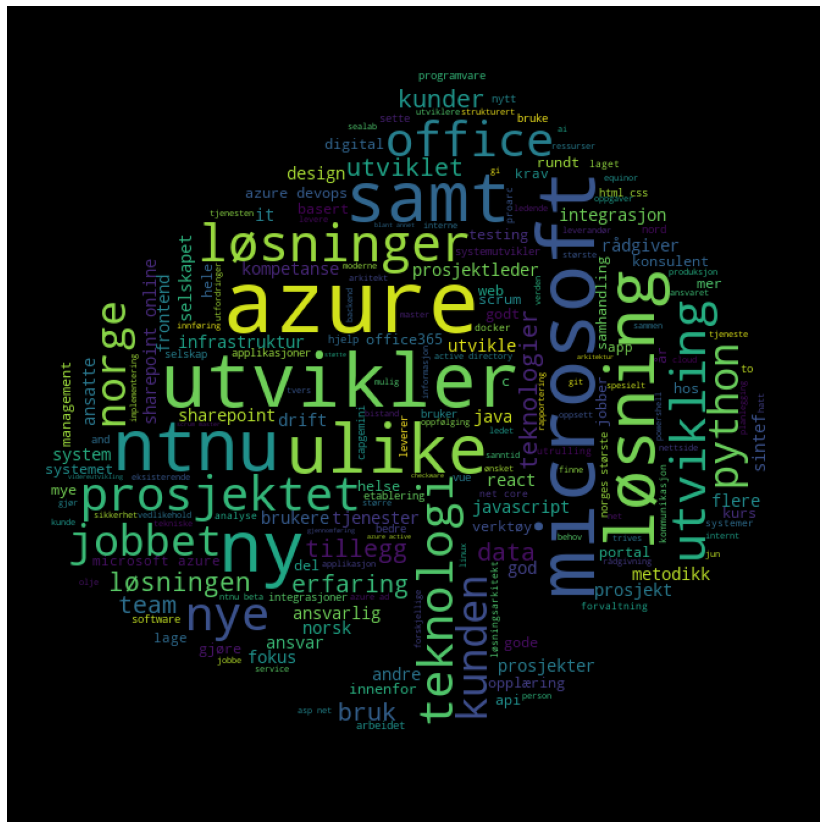

In [323]:
from PIL import Image

logo_path = os.path.join(os.getcwd(), 'data', 'cap.jpg')
generated_logo_path = os.path.join(os.getcwd(), 'data', 'cap-cloud.jpg')
cap_mask = np.array(Image.open(logo_path))

def create_masked_wc(data):
    wc = WordCloud(background_color="black",
                   max_words=200,
                   max_font_size=70,
                   mask=cap_mask,
                   stopwords=FY_ORD,
                   contour_width=0,
                   width=1000,
                   height=1000)

    wc.generate(' '.join(data))

    # store to file
    # wc.to_file(generated_logo_path)

    # show
    plt.figure(figsize=(15,15))
    plt.imshow(wc)
    plt.axis("off")
    plt.show()

create_masked_wc(corpus)

In [324]:
lemmas = [' '.join(x) for x in list(df.lemmas)]
ents = [e for e in list(df.ents) if len(e) > 0]
ents = [e[0] for e in flat_map(ents)]
ents[:10]

['Albert',
 'NTNU',
 'Albert',
 'Altera Infrastructure',
 'Vue',
 'Azure DevOps',
 'Albert',
 'Sjøfartsdirektoratet',
 'APS',
 'Personell Sertifikat']

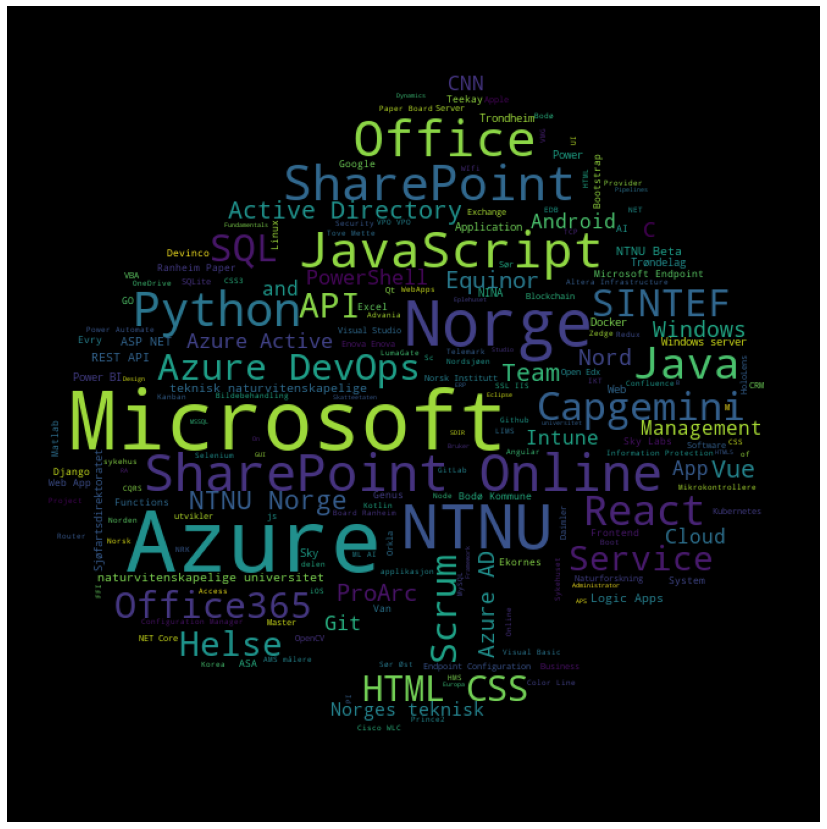

In [325]:
create_masked_wc(ents)

## n-grams

In [326]:
from nltk.util import ngrams
from sklearn.feature_extraction.text import CountVectorizer

def get_top_ngram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(n, n)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) 
                  for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:10]

['Albert',
 'NTNU',
 'Albert',
 'Altera Infrastructure',
 'Vue',
 'Azure DevOps',
 'Albert',
 'Sjøfartsdirektoratet',
 'APS',
 'Personell Sertifikat',
 'React',
 'Azure Functions',
 'Alberts',
 'SINTEF',
 'AR/VR',
 'Equinor',
 'Microsoft',
 'HoloLens',
 'Samsung HMD Odyssey',
 'Albert',
 'Azure DevOps',
 '.NET',
 'Git',
 'Vue',
 'React',
 'JavaScript',
 'CSS',
 'HTML',
 'Power BI',
 'Unity',
 'SolidWorks',
 'Autodesk Eagle',
 'Python',
 'HTML5',
 'JavaScript',
 'CSS3.',
 'Albert',
 'Altera Infrastructure',
 'Azure DevOps',
 'Azure',
 '.NET',
 'Vue',
 'Bootstrap',
 'Cypres',
 'Teekay',
 'Vue',
 'Bootstrap',
 '.NET',
 'Sjøfartsdirektoratet',
 'SDIR',
 'APS',
 'SINTEF',
 'SINTEF',
 'iProcess',
 'Python',
 'FreeRTOS',
 'Hoff Handel',
 'Trondheim',
 'Sirkus Shopping',
 'Django',
 'Vue',
 'Vue',
 'Javascript',
 'SQLite',
 'Scrum',
 'SINTEF',
 'Processing',
 'HoloLens',
 'Power BI',
 'HoloLens',
 'Power BI',
 'HoloLens',
 'Microsoft',
 'Office 365',
 'Power BI',
 'Teams',
 'B.Sc',
 'SINTEF',


In [ ]:
get_top_ngram(lemmas, 2)

In [301]:
get_top_ngram(lemmas, 3)

[('metodikk og teknologi', 16),
 ('ha ansvar for', 10),
 ('ved hjelp av', 9),
 ('sette seg inn', 9),
 ('på tvers av', 8),
 ('azure active directory', 8),
 ('og utvikling av', 7),
 ('norges teknisk naturvitenskapelig', 7),
 ('teknisk naturvitenskapelig universitet', 7),
 ('er norges størst', 7)]

In [304]:
get_top_ngram(lemmas, 4)

[('norges teknisk naturvitenskapelig universitet', 7),
 ('2018 jun 2018 aug', 6),
 ('office 365 sharepoint online', 6),
 ('sette seg inn ny', 5),
 ('ntnu er norges størst', 5),
 ('er norges størst universitet', 5),
 ('teknisk naturvitenskapelig universitet ntnu', 5),
 ('har han jobbe med', 4),
 ('microsoft 365 office 365', 4),
 ('de sist åre har', 4)]

In [ ]:
get_top_ngram(lemmas, 4)